In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer

np.random.seed(42)

entrenamiento = pd.read_csv('train.csv')
testeo = pd.read_csv('test.csv')
muestra = pd.read_csv('sample_submission.csv')

In [2]:
import re
import string
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

def preprocess_keyword(keyword):
    if isinstance(keyword, str):
        processed_keyword = keyword.replace('%20', '_')
        return processed_keyword.strip().lower()
    return keyword

def preprocess_location(location):
    if isinstance(location, str):
        processed_location = location.replace('%20', '_')
        return processed_location
    return location

def preprocess_text(text):
    text = text.lower()

    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    text = text.replace('!', ' EXCLAMATION ')
    text = text.replace('?', ' QUESTION ')

    text = text.translate(str.maketrans('', '', string.punctuation))

    tokens = nltk.word_tokenize(text)

    return tokens

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## Split entre entrenamiento y validación

In [3]:
def to_text_raw(x):
    if isinstance(x, list):
        return " ".join(map(str, x))
    return str(x)

X = entrenamiento.drop(['target'], axis=1)
y = entrenamiento['target']

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train['text_orig'] = X_train['text'].astype(str)
X_validation['text_orig'] = X_validation['text'].astype(str)

X_train['text'] = X_train['text'].apply(preprocess_text)
X_validation['text'] = X_validation['text'].apply(preprocess_text)
X_train['location'] = X_train['location'].apply(preprocess_location)
X_validation['location'] = X_validation['location'].apply(preprocess_location)
X_train['keyword'] = X_train['keyword'].apply(preprocess_keyword)
X_validation['keyword'] = X_validation['keyword'].apply(preprocess_keyword)

X_train['text_raw'] = X_train['text'].apply(to_text_raw)
X_validation['text_raw'] = X_validation['text'].apply(to_text_raw)

In [4]:
from scipy.stats import uniform, randint, loguniform

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    tree_method='hist',
    n_jobs=-1,
    eval_metric='aucpr',
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    early_stopping_rounds=50,
)

parametros_xgb = {
    'learning_rate': loguniform(2e-2, 1e-1),
    'max_depth': randint(3, 5),
    'min_child_weight': randint(5, 10),
    'subsample': uniform(0.7, 0.25),
    'colsample_bytree': uniform(0.7, 0.25),
    'gamma': uniform(0.5, 3.0),
    'reg_alpha': loguniform(0.1, 5.0),
    'reg_lambda': loguniform(1.0, 10.0),
    'n_estimators': randint(150, 400),
}

## Búsqueda de hiperparámetros

In [5]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rs = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=parametros_xgb,
    n_iter=100,
    scoring='f1',
    cv=skf,
    verbose=1,
    n_jobs=-1,
    random_state=42,
)

## Creación de features numéricas

In [6]:
X_train['word_count'] = X_train['text'].apply(len)
X_validation['word_count'] = X_validation['text'].apply(len)

X_train['avg_word_length'] = X_train['text'].apply(lambda x: sum(len(word) for word in x) / len(x) if len(x) > 0 else 0)
X_validation['avg_word_length'] = X_validation['text'].apply(lambda x: sum(len(word) for word in x) / len(x) if len(x) > 0 else 0)

X_train['unique_word_count'] = X_train['text'].apply(lambda x: len(set(x)))
X_validation['unique_word_count'] = X_validation['text'].apply(lambda x: len(set(x)))

X_train['lexical_diversity'] = X_train['unique_word_count'] / X_train['word_count']
X_validation['lexical_diversity'] = X_validation['unique_word_count'] / X_validation['word_count']

In [7]:
X_train['mention_count'] = X_train['text'].apply(lambda x: sum(1 for word in x if word.startswith('@')))
X_validation['mention_count'] = X_validation['text'].apply(lambda x: sum(1 for word in x if word.startswith('@')))

X_train['hashtag_count'] = X_train['text'].apply(lambda x: sum(1 for word in x if word.startswith('#')))
X_validation['hashtag_count'] = X_validation['text'].apply(lambda x: sum(1 for word in x if word.startswith('#')))

X_train['has_exclamation'] = X_train['text'].apply(lambda x: 1 if 'EXCLAMATION' in x else 0)
X_validation['has_exclamation'] = X_validation['text'].apply(lambda x: 1 if 'EXCLAMATION' in x else 0)

X_train['has_question'] = X_train['text'].apply(lambda x: 1 if 'QUESTION' in x else 0)
X_validation['has_question'] = X_validation['text'].apply(lambda x: 1 if 'QUESTION' in x else 0)

In [8]:
import re
import numpy as np
from scipy.sparse import csr_matrix, hstack

def feat_num_from_df(df):
    s = df['text_orig']

    exclam_count = s.apply(lambda x: x.count('!')).astype(float)
    quest_count  = s.apply(lambda x: x.count('?')).astype(float)
    has_url      = s.apply(lambda x: 1.0 if ('http' in x or 'www.' in x or '.com' in x) else 0.0)
    hashtag_count = s.apply(lambda x: x.count('#')).astype(float)

    def upper_ratio_fun(x):
        letters = [ch for ch in x if ch.isalpha()]
        if not letters:
            return 0.0
        return sum(1 for ch in letters if ch.isupper()) / len(letters)

    upper_ratio = s.apply(upper_ratio_fun).astype(float)

    feats = np.vstack([
        exclam_count.values,
        quest_count.values,
        has_url.values,
        hashtag_count.values,
        upper_ratio.values
    ]).T

    return csr_matrix(feats)

X_train_num = feat_num_from_df(X_train)
X_val_num   = feat_num_from_df(X_validation)

In [9]:
import re
import numpy as np
from scipy.sparse import csr_matrix, hstack

ELONG_RE = re.compile(r'(.)\1{2,}', re.UNICODE)

def elongated_ratio_from_text(x: str) -> float:
    tokens = re.findall(r"[A-Za-z]+", x)
    n = len(tokens)
    if n == 0:
        return 0.0
    elongated = sum(1 for t in tokens if ELONG_RE.search(t))
    return elongated / n


X_train_elong = csr_matrix(
    X_train['text_orig'].apply(elongated_ratio_from_text).values.reshape(-1, 1)
)
X_val_elong = csr_matrix(
    X_validation['text_orig'].apply(elongated_ratio_from_text).values.reshape(-1, 1)
)

## Creación de features categóricas

In [10]:
def categorize_length(word_count):
    if word_count <= 5:
        return 'muy_corto'
    elif word_count <= 10:
        return 'corto'
    elif word_count <= 15:
        return 'medio'
    else:
        return 'largo'

X_train['length_category'] = X_train['word_count'].apply(categorize_length)
X_validation['length_category'] = X_validation['word_count'].apply(categorize_length)

urgency_words = {'fire', 'emergency', 'disaster', 'evacuate', 'help', 'urgent', 'alert',
                 'warning', 'danger', 'crisis', 'rescue', 'trapped', 'injured', 'death',
                 'killed', 'destroyed', 'damage', 'severe', 'threat', 'risk'}

def has_urgency_words(tokens):
    return 'si' if any(word in urgency_words for word in tokens) else 'no'

X_train['has_urgency'] = X_train['text'].apply(has_urgency_words)
X_validation['has_urgency'] = X_validation['text'].apply(has_urgency_words)

def categorize_diversity(diversity):
    if diversity < 0.5:
        return 'baja'
    elif diversity < 0.75:
        return 'media'
    else:
        return 'alta'

X_train['diversity_category'] = X_train['lexical_diversity'].apply(categorize_diversity)
X_validation['diversity_category'] = X_validation['lexical_diversity'].apply(categorize_diversity)

In [11]:
X_train['keyword'] = X_train['keyword'].fillna('unknown')
X_validation['keyword'] = X_validation['keyword'].fillna('unknown')

X_train['location'] = X_train['location'].fillna('unknown')
X_validation['location'] = X_validation['location'].fillna('unknown')

cat_features = ['keyword', 'length_category', 'has_urgency', 'diversity_category']

In [12]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 51.6 MB/s eta 0:00:00


## Embedding del texto

In [13]:
import os

try:
    from gensim.models import KeyedVectors
    from gensim.downloader import load
    import gensim.downloader as api

    model_name = 'glove-twitter-50'

    model_path = os.path.join(os.path.expanduser('~'), 'gensim-data', model_name)

    if os.path.exists(model_path):
        print(f"Embeddings '{model_name}' ya descargados")
    else:
        print(f"Descargando '{model_name}'...")

    word_vectors = load(model_name)
    embedding_dim = word_vectors.vector_size
    print(f"Embeddings cargados: {embedding_dim} dimensiones")

except Exception as e:
    print(f"Error: {e}")
    word_vectors = None
    embedding_dim = 50

def text_to_embedding(tokens, word_vectors, embedding_dim):
    if word_vectors is not None:
        embeddings = []
        for word in tokens:
            try:
                embeddings.append(word_vectors[word])
            except KeyError:
                pass

        if len(embeddings) > 0:
            return np.mean(embeddings, axis=0)
        else:
            return np.zeros(embedding_dim)
    else:
        return np.zeros(embedding_dim)

X_train_embeddings = np.array([text_to_embedding(tokens, word_vectors, embedding_dim)
                                for tokens in X_train['text']])
X_validation_embeddings = np.array([text_to_embedding(tokens, word_vectors, embedding_dim)
                                     for tokens in X_validation['text']])

tfidf = TfidfVectorizer(
    max_features=20,
    tokenizer=lambda x: x,
    preprocessor=lambda x: x,
    ngram_range=(1, 3),
    min_df=2,
    max_df=0.90,
    sublinear_tf=True,
    lowercase=True,
    strip_accents='unicode',
    analyzer='word',
    norm='l2',
    use_idf=True,
    stop_words=None
)

char_vec = TfidfVectorizer(
    analyzer='char',
    ngram_range=(3, 6),
    min_df=3,
    max_features=20,
    lowercase=True,
    sublinear_tf=True,
    strip_accents='unicode'
)

X_train_char = char_vec.fit_transform(X_train['text_raw'])
X_val_char   = char_vec.transform(X_validation['text_raw'])

X_train_tfidf = tfidf.fit_transform(X_train['text'])
X_validation_tfidf = tfidf.transform(X_validation['text'])

print(f"Embeddings: {X_train_embeddings.shape}, TF-IDF: {X_train_tfidf.shape}")
print(f"Embeddings: {X_train_embeddings.shape}, TF-IDF: {X_train_char.shape}")

Descargando 'glove-twitter-50'...
[==================================================] 100.0% 199.5/199.5MB downloaded
Embeddings cargados: 50 dimensiones


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Embeddings: (6090, 50), TF-IDF: (6090, 20)
Embeddings: (6090, 50), TF-IDF: (6090, 20)


## One Hot Encoding

In [14]:
from sklearn.preprocessing import OneHotEncoder

one_hot_enc = OneHotEncoder(
    handle_unknown='infrequent_if_exist',
    sparse_output=True,
    max_categories=50,
    min_frequency=10
)
X_train_cat_encoded = one_hot_enc.fit_transform(X_train[cat_features])
X_validation_cat_encoded = one_hot_enc.transform(X_validation[cat_features])

print(f"One-Hot Encoding: {X_train_cat_encoded.shape[1]} features generadas")

One-Hot Encoding: 59 features generadas


## Mean Encoding

In [15]:
class MeanEncoder:
	def __init__(self, categorical_features, target_col='target', alpha=10):
		self.categorical_features = categorical_features
		self.target_col = target_col
		self.alpha = alpha
		self.mean_encodings = {}
		self.global_mean = None

	def fit(self, X, y):
		"""Calculate mean encodings for each categorical feature"""
		self.global_mean = y.mean()

		for col in self.categorical_features:
			agg = pd.DataFrame({col: X[col], self.target_col: y})
			counts = agg.groupby(col).size()
			means = agg.groupby(col)[self.target_col].mean()

			smooth_means = (counts * means + self.alpha * self.global_mean) / (counts + self.alpha)
			self.mean_encodings[col] = smooth_means.to_dict()

		return self

	def transform(self, X):
		"""Transform categorical features to mean encodings"""
		X_encoded = X.copy()

		for col in self.categorical_features:
			X_encoded[col + '_mean_encoded'] = X[col].map(self.mean_encodings[col]).fillna(self.global_mean)

		return X_encoded

	def fit_transform(self, X, y):
		"""Fit and transform in one step"""
		self.fit(X, y)
		return self.transform(X)

mean_encoder = MeanEncoder(categorical_features=cat_features, alpha=10)
X_train_mean_encoded = mean_encoder.fit_transform(X_train, y_train)
X_validation_mean_encoded = mean_encoder.transform(X_validation)

## Entrenamiento del modelo

In [16]:
from scipy.sparse import hstack
from scipy.sparse import csr_matrix

numeric_features = ['word_count', 'avg_word_length', 'unique_word_count', 'lexical_diversity',
                     'mention_count', 'hashtag_count', 'has_exclamation', 'has_question']

X_train_numeric = X_train_mean_encoded[numeric_features].values
X_validation_numeric = X_validation_mean_encoded[numeric_features].values

X_train_embeddings_sparse = csr_matrix(X_train_embeddings)
X_validation_embeddings_sparse = csr_matrix(X_validation_embeddings)

X_train_numeric_sparse = csr_matrix(X_train_numeric)
X_validation_numeric_sparse = csr_matrix(X_validation_numeric)

mean_encoded_cols = [col + '_mean_encoded' for col in cat_features]
X_train_mean_encoded_values = X_train_mean_encoded[mean_encoded_cols].values
X_validation_mean_encoded_values = X_validation_mean_encoded[mean_encoded_cols].values

X_train_mean_encoded_sparse = csr_matrix(X_train_mean_encoded_values)
X_validation_mean_encoded_sparse = csr_matrix(X_validation_mean_encoded_values)

X_train_final = hstack([
    X_train_tfidf,
    X_train_embeddings_sparse,
    X_train_cat_encoded,
    X_train_mean_encoded_sparse,
    X_train_numeric_sparse
])
X_validation_final = hstack([
    X_validation_tfidf,
    X_validation_embeddings_sparse,
    X_validation_cat_encoded,
    X_validation_mean_encoded_sparse,
    X_validation_numeric_sparse
])

print(f"Dataset entrenamiento: {X_train_final.shape}")
print(f"Dataset validacion: {X_validation_final.shape}")
print(f"Breakdown - TF-IDF: {X_train_tfidf.shape[1]}, Embeddings: {X_train_embeddings_sparse.shape[1]}, One-Hot: {X_train_cat_encoded.shape[1]}, Mean: {X_train_mean_encoded_sparse.shape[1]}, Numericas: {X_train_numeric_sparse.shape[1]}")

X_train_aug = hstack([X_train_final, X_train_char], format='csr')
X_val_aug   = hstack([X_validation_final, X_val_char], format='csr')

X_train_full = hstack([X_train_aug, X_train_num], format='csr')
X_val_full   = hstack([X_val_aug,   X_val_num],   format='csr')

X_train_full_plus = hstack([X_train_full, X_train_elong], format='csr')
X_val_full_plus   = hstack([X_val_full,   X_val_elong],   format='csr')

fit_params = {
    'eval_set': [(X_val_full_plus, y_validation)],
    'verbose': False
}

rs.fit(X_train_full_plus, y_train, **fit_params)

Dataset entrenamiento: (6090, 141)
Dataset validacion: (1523, 141)
Breakdown - TF-IDF: 20, Embeddings: 50, One-Hot: 59, Mean: 4, Numericas: 8
Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=50,
                                           enable_categorical=False,
                                           eval_metric='aucpr',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           gro...
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7b47c8a893d0>,
                                        'reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7b47c7f6d7c0>,
                                        'reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7b47c7f6d280>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7b47c7f6d490>},
                   random_state=42, scoring='f1', verbose=1)

## Evaluación del modelo

In [17]:
from sklearn.metrics import f1_score

y_pred_validation = rs.predict(X_val_full_plus)
y_pred_train = rs.predict(X_train_full_plus)

print(f"F1 validacion: {f1_score(y_validation, y_pred_validation):.4f}")
print(f"F1 entrenamiento: {f1_score(y_train, y_pred_train):.4f}")
print(f"Gap: {f1_score(y_train, y_pred_train) - f1_score(y_validation, y_pred_validation):.4f}")

F1 validacion: 0.7833
F1 entrenamiento: 0.8563
Gap: 0.0730


In [18]:
from sklearn.metrics import classification_report

print("Validacion:")
print(classification_report(y_validation, y_pred_validation, target_names=['No Desastre', 'Desastre']))

print("\nEntrenamiento:")
print(classification_report(y_train, y_pred_train, target_names=['No Desastre', 'Desastre']))

print("\nMejor configuracion:")
print(rs.best_params_)
print(f"Mejor score CV: {rs.best_score_:.4f}")

print(f"\nBalance clases - Train: 0={(y_train == 0).sum()}, 1={(y_train == 1).sum()}")
print(f"Balance clases - Valid: 0={(y_validation == 0).sum()}, 1={(y_validation == 1).sum()}")

Validacion:
              precision    recall  f1-score   support

 No Desastre       0.83      0.85      0.84       869
    Desastre       0.79      0.77      0.78       654

    accuracy                           0.82      1523
   macro avg       0.81      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523


Entrenamiento:
              precision    recall  f1-score   support

 No Desastre       0.88      0.91      0.90      3473
    Desastre       0.87      0.84      0.86      2617

    accuracy                           0.88      6090
   macro avg       0.88      0.87      0.88      6090
weighted avg       0.88      0.88      0.88      6090


Mejor configuracion:
{'colsample_bytree': np.float64(0.8672103131659018), 'gamma': np.float64(2.49776706985249), 'learning_rate': np.float64(0.051799958630660316), 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 184, 'reg_alpha': np.float64(0.6342770438858341), 'reg_lambda': np.float64(1.3170256885255098), 's

In [19]:
y_pred_proba_validation = rs.predict_proba(X_val_full_plus)[:, 1]

thresholds = np.linspace(0.01, 0.99, 200)
f1_scores_th = []

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba_validation >= threshold).astype(int)
    f1 = f1_score(y_validation, y_pred_threshold)
    f1_scores_th.append(f1)

best_idx = np.argmax(f1_scores_th)
best_threshold = thresholds[best_idx]
best_f1 = f1_scores_th[best_idx]

print(f"\nOptimizacion de threshold:")
print(f"Default (0.5): {f1_score(y_validation, y_pred_validation):.4f}")
print(f"Mejor threshold: {best_threshold:.2f} -> F1: {best_f1:.4f}")
print(f"Mejora: +{(best_f1 - f1_score(y_validation, y_pred_validation)):.4f}")


Optimizacion de threshold:
Default (0.5): 0.7833
Mejor threshold: 0.63 -> F1: 0.7867
Mejora: +0.0034


## Predicciones en el conjunto de test

In [ ]:
testeo['text'] = testeo['text'].apply(preprocess_text)
testeo['keyword'] = testeo['keyword'].apply(preprocess_keyword)
testeo['location'] = testeo['location'].apply(preprocess_location)

testeo['word_count'] = testeo['text'].apply(len)
testeo['avg_word_length'] = testeo['text'].apply(lambda x: sum(len(word) for word in x) / len(x) if len(x) > 0 else 0)
testeo['unique_word_count'] = testeo['text'].apply(lambda x: len(set(x)))
testeo['lexical_diversity'] = testeo['unique_word_count'] / testeo['word_count']

testeo['mention_count'] = testeo['text'].apply(lambda x: sum(1 for word in x if word.startswith('@')))
testeo['hashtag_count'] = testeo['text'].apply(lambda x: sum(1 for word in x if word.startswith('#')))
testeo['has_exclamation'] = testeo['text'].apply(lambda x: 1 if 'EXCLAMATION' in x else 0)
testeo['has_question'] = testeo['text'].apply(lambda x: 1 if 'QUESTION' in x else 0)

testeo['length_category'] = testeo['word_count'].apply(categorize_length)
testeo['has_urgency'] = testeo['text'].apply(has_urgency_words)
testeo['diversity_category'] = testeo['lexical_diversity'].apply(categorize_diversity)

testeo['keyword'] = testeo['keyword'].fillna('unknown')
testeo['location'] = testeo['location'].fillna('unknown')

X_test_embeddings = np.array([text_to_embedding(tokens, word_vectors, embedding_dim)
                               for tokens in testeo['text']])
X_test_embeddings_sparse = csr_matrix(X_test_embeddings)

X_test_tfidf = tfidf.transform(testeo['text'])

X_test_cat_encoded = one_hot_enc.transform(testeo[cat_features])

testeo_mean_encoded = mean_encoder.transform(testeo)
X_test_mean_encoded_values = testeo_mean_encoded[mean_encoded_cols].values
X_test_mean_encoded_sparse = csr_matrix(X_test_mean_encoded_values)

X_test_numeric = testeo[numeric_features].values
X_test_numeric_sparse = csr_matrix(X_test_numeric)

X_test_final = hstack([
    X_test_tfidf,
    X_test_embeddings_sparse,
    X_test_cat_encoded,
    X_test_mean_encoded_sparse,
    X_test_numeric_sparse
])

y_pred_proba_test = rs.predict_proba(X_test_final)[:, 1]
predicciones = (y_pred_proba_test >= best_threshold).astype(int)

submission = pd.DataFrame({
    'id': testeo['id'],
    'target': predicciones
})

submission.to_csv('submission_xgb.csv', index=False)
print(f"Submission guardado: {len(predicciones)} predicciones")
print(f"Distribucion - 0: {(predicciones == 0).sum()}, 1: {(predicciones == 1).sum()}")

## Análisis de curva ROC

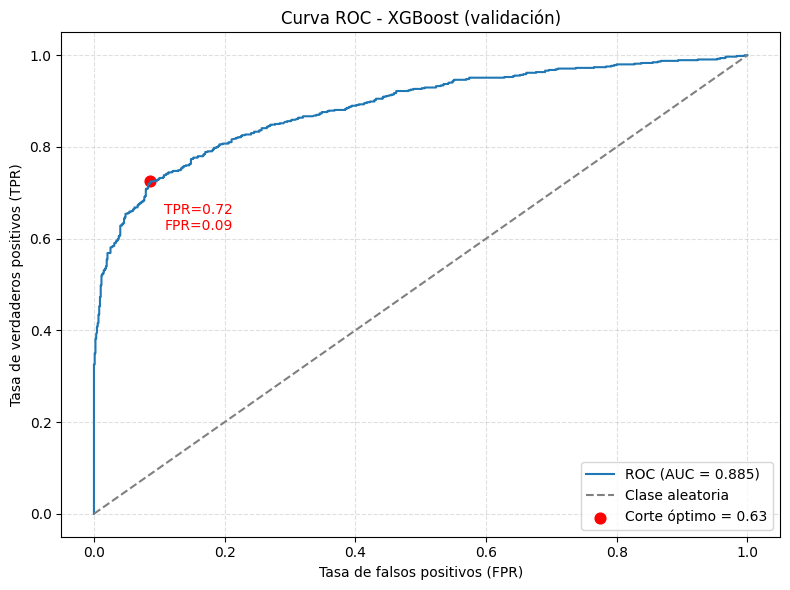

El umbral optimizado (0.63) ofrece TPR=0.72 y FPR=0.09, mientras que el corte estándar 0.50 da TPR=0.77 y FPR=0.15.


In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds_roc = roc_curve(y_validation, y_pred_proba_validation)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})')
ax.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Clase aleatoria')

best_idx_roc = int(np.argmin(np.abs(thresholds_roc - best_threshold)))
ax.scatter(fpr[best_idx_roc], tpr[best_idx_roc], color='red', s=60, label=f'Corte óptimo = {best_threshold:.2f}')
ax.annotate(
    f'TPR={tpr[best_idx_roc]:.2f}\nFPR={fpr[best_idx_roc]:.2f}',
    (fpr[best_idx_roc], tpr[best_idx_roc]),
    textcoords='offset points',
    xytext=(10, -35),
    ha='left',
    color='red'
)

ax.set_xlabel('Tasa de falsos positivos (FPR)')
ax.set_ylabel('Tasa de verdaderos positivos (TPR)')
ax.set_title('Curva ROC - XGBoost (validación)')
ax.legend(loc='lower right')
ax.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

default_idx = int(np.argmin(np.abs(thresholds_roc - 0.5)))
print(
    f"El umbral optimizado ({best_threshold:.2f}) ofrece TPR={tpr[best_idx_roc]:.2f} y FPR={fpr[best_idx_roc]:.2f}, "
    f"mientras que el corte estándar 0.50 da TPR={tpr[default_idx]:.2f} y FPR={fpr[default_idx]:.2f}."
)

## Análisis de feature importance

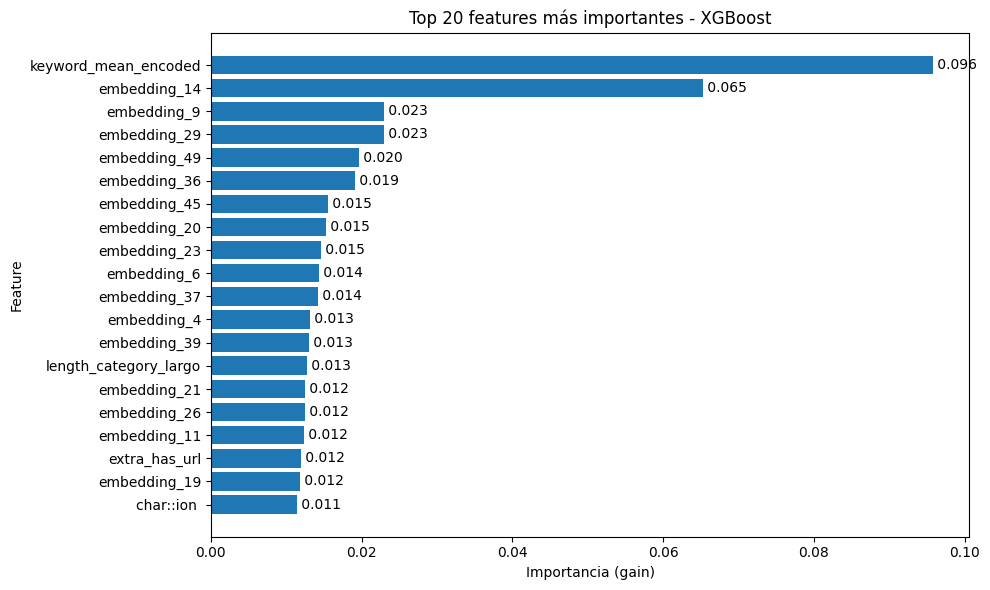

Las features más influyentes son: keyword_mean_encoded (0.096), embedding_14 (0.065), embedding_9 (0.023).


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tfidf_feature_names = [f"tfidf::{term}" for term in tfidf.get_feature_names_out()]
embedding_feature_names = [f"embedding_{i}" for i in range(X_train_embeddings_sparse.shape[1])]
one_hot_feature_names = one_hot_enc.get_feature_names_out(cat_features).tolist()
mean_encoded_feature_names = mean_encoded_cols
numeric_feature_names = numeric_features
char_feature_names = [f"char::{term}" for term in char_vec.get_feature_names_out()]
extra_feature_names = ['extra_exclam_count', 'extra_question_count', 'extra_has_url', 'extra_hashtag_count', 'extra_upper_ratio']
if X_train_num.shape[1] != len(extra_feature_names):
    extra_feature_names = [f'extra_feature_{i}' for i in range(X_train_num.shape[1])]
elongation_feature_names = ['elongated_ratio']

feature_name_list = (
    tfidf_feature_names +
    embedding_feature_names +
    one_hot_feature_names +
    mean_encoded_feature_names +
    numeric_feature_names +
    char_feature_names +
    extra_feature_names +
    elongation_feature_names
)

importance_values = np.array(rs.best_estimator_.feature_importances_)
if len(feature_name_list) != len(importance_values):
    min_len = min(len(feature_name_list), len(importance_values))
    print(
        f"Advertencia: se encontraron {len(feature_name_list)} nombres de features y {len(importance_values)} importancias; "
        f"se usará la intersección de {min_len}."
    )
    feature_name_list = feature_name_list[:min_len]
    importance_values = importance_values[:min_len]

fi_df = (
    pd.DataFrame({'feature': feature_name_list, 'importance': importance_values})
    .sort_values('importance', ascending=False)
    .head(20)
    .sort_values('importance', ascending=True)
)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(fi_df['feature'], fi_df['importance'], color='#1f77b4')
ax.set_xlabel('Importancia (gain)')
ax.set_ylabel('Feature')
ax.set_title('Top 20 features más importantes - XGBoost')
for i, (imp, feat) in enumerate(zip(fi_df['importance'], fi_df['feature'])):
    ax.text(imp, i, f" {imp:.3f}", va='center')
plt.tight_layout()
plt.show()

top_features = fi_df.sort_values('importance', ascending=False).head(3)
top_text = ', '.join([f"{row.feature} ({row.importance:.3f})" for row in top_features.itertuples()])
print(f"Las features más influyentes son: {top_text}.")

## Análisis de matriz de confusión

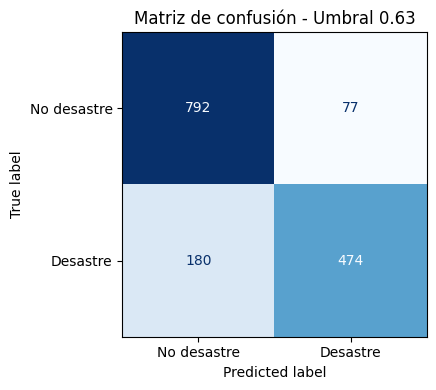

Validación con corte 0.63: Precision=0.860, Recall=0.725, F1=0.787, Specificity=0.911
Falsos positivos: 77, Falsos negativos: 180. 


In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

y_val_opt = (y_pred_proba_validation >= best_threshold).astype(int)
cm = confusion_matrix(y_validation, y_val_opt)

fig, ax = plt.subplots(figsize=(5, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No desastre', 'Desastre'])
disp.plot(ax=ax, colorbar=False, cmap='Blues')
ax.set_title(f'Matriz de confusión - Umbral {best_threshold:.2f}')
plt.tight_layout()
plt.show()

tn, fp, fn, tp = cm.ravel()
precision = precision_score(y_validation, y_val_opt)
recall = recall_score(y_validation, y_val_opt)
f1 = f1_score(y_validation, y_val_opt)
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0

print(
    f"Validación con corte {best_threshold:.2f}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}, Specificity={specificity:.3f}"
)
print(
    f"Falsos positivos: {fp}, Falsos negativos: {fn}. "
)